# OAT-FR10: Analysis and Backcasting of France 10-Year OAT Yields

## Notebook Summary

This notebook performs a comprehensive analysis of France 10-Year OAT (Obligations Assimilables du Trésor) yields, integrating OAT data and FR10YT_RR data to extend the historical series through backcasting.

### Analysis Structure

#### 1. **Daily to Monthly Conversion (2004-2025)**
   - Reads daily data from `FRANCE_10_YEARS_DAILY_YIELDS.csv`
   - Calculates monthly averages of daily yields
   - Assigns date to the last day of each month
   - Output: `FRANCE_10_YEARS_MONTHLY_YIELDS.csv` (254 monthly observations)

#### 2. **OLS Linear Regression: TEC10_m vs FR10_m**
   - Aligns monthly OAT (TEC10_m) and FR10YT_RR (FR10_m) data for the common period
   - Estimates a linear regression model using `statsmodels`:
     - **Equation**: `TEC10_m = α + β × FR10_m`
   - Visualization via scatter plot with regression line

#### 3. **Monthly Backcasting (2000-2004)**
   - Uses estimated regression parameters to backcast TEC10_m for the period 2000-2004
   - Applies regression equation to available FR10_m data
   - Output: `FRANCE_10_YEARS_MONTHLY_YIELDS_BACKCASTED_FR10_2000_2004.csv`

#### 4. **Linear Interpolation: Monthly → Daily (2000-2004)**
   - Creates a complete daily date range for the period 2000-2004
   - Linear interpolation between backcasted monthly values to obtain daily values
   - Output: `FRANCE_10_YEARS_DAILY_YIELDS_BACKCASTED_FR10_2000_2004.csv`

#### 5. **Merging Backcasted and Actual Data**
   - Merges backcasted daily data (2000-2004) with actual data (2004+)
   - **Priority**: Actual data takes priority when dates overlap
   - **Gap handling**: Applies backward fill (bfill) to fill any gaps in the series
   - Final output: `FRANCE_10_YEARS_DAILY_YIELDS_MERGED_FR10.csv`

### Methodology

The backcasting is based on the assumption that the relationship between TEC10_m and FR10_m observed in the period 2004-2025 is stable and can be applied retroactively to the period 2000-2004.


In [1]:
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')


In [2]:
# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define input and output files
input_file = 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS.csv'
output_file = 'data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS.csv'

# Check that the input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"File not found: {input_file}")

print(f"Input file: {input_file}")
print(f"Output file: {output_file}")


Working directory: /workspace
Input file: data/oat/FRANCE_10_YEARS_DAILY_YIELDS.csv
Output file: data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS.csv


In [3]:
# Read the daily yields CSV file
print("Reading daily yields CSV file...")
df_daily = pd.read_csv(input_file)

print(f"Data shape: {df_daily.shape}")
print(f"\nColumn names:")
print(df_daily.columns.tolist())
print(f"\nFirst few rows:")
print(df_daily.head(10))
print(f"\nLast few rows:")
print(df_daily.tail(10))


Reading daily yields CSV file...
Data shape: (7703, 2)

Column names:
['date', 'value']

First few rows:
         date  value
0  2004-11-03   3.97
1  2004-11-04   3.93
2  2004-11-05   3.91
3  2004-11-06   3.96
4  2004-11-07   3.96
5  2004-11-08   3.96
6  2004-11-09   3.95
7  2004-11-10   3.92
8  2004-11-11   3.90
9  2004-11-12   3.85

Last few rows:
            date  value
7693  2025-11-26   3.41
7694  2025-11-27   3.41
7695  2025-11-28   3.41
7696  2025-11-29   3.45
7697  2025-11-30   3.45
7698  2025-12-01   3.45
7699  2025-12-02   3.49
7700  2025-12-03   3.50
7701  2025-12-04   3.50
7702  2025-12-05   3.53


In [4]:
# Convert date column to datetime
df_daily['date'] = pd.to_datetime(df_daily['date'], format='%Y-%m-%d', errors='coerce')

# Remove rows with invalid dates
df_daily = df_daily[df_daily['date'].notna()].copy()

# Ensure value column is numeric
df_daily['value'] = pd.to_numeric(df_daily['value'], errors='coerce')

# Remove rows with invalid values
df_daily = df_daily[df_daily['value'].notna()].copy()

# Sort by date
df_daily = df_daily.sort_values(by='date').reset_index(drop=True)

print(f"Date range: {df_daily['date'].min()} to {df_daily['date'].max()}")
print(f"Total daily rows: {len(df_daily)}")
print(f"\nFirst few rows:")
print(df_daily.head(10))


Date range: 2004-11-03 00:00:00 to 2025-12-05 00:00:00
Total daily rows: 7703

First few rows:
        date  value
0 2004-11-03   3.97
1 2004-11-04   3.93
2 2004-11-05   3.91
3 2004-11-06   3.96
4 2004-11-07   3.96
5 2004-11-08   3.96
6 2004-11-09   3.95
7 2004-11-10   3.92
8 2004-11-11   3.90
9 2004-11-12   3.85


In [5]:
# Create year-month column for grouping
df_daily['year_month'] = df_daily['date'].dt.to_period('M')

# Group by year-month and calculate monthly average
df_monthly = df_daily.groupby('year_month')['value'].mean().reset_index()
df_monthly.columns = ['year_month', 'value']

print(f"Monthly averages calculated: {len(df_monthly)} months")
print(f"\nFirst few rows:")
print(df_monthly.head(10))


Monthly averages calculated: 254 months

First few rows:
  year_month     value
0    2004-11  3.851786
1    2004-12  3.646774
2    2005-01  3.593226
3    2005-02  3.588929
4    2005-03  3.748065
5    2005-04  3.540000
6    2005-05  3.389032
7    2005-06  3.210333
8    2005-07  3.247419
9    2005-08  3.280323


In [6]:
# Convert period to datetime and get the last day of each month
# Using to_timestamp with how='end' to get the last day of the month
df_monthly['date'] = df_monthly['year_month'].dt.to_timestamp(how='end')

# Select only date and value columns
df_output = df_monthly[['date', 'value']].copy()

print(f"Final monthly data: {len(df_output)} rows")
print(f"Date range: {df_output['date'].min()} to {df_output['date'].max()}")
print(f"\nFirst few rows:")
print(df_output.head(10))
print(f"\nLast few rows:")
print(df_output.tail(10))


Final monthly data: 254 rows
Date range: 2004-11-30 23:59:59.999999999 to 2025-12-31 23:59:59.999999999

First few rows:
                           date     value
0 2004-11-30 23:59:59.999999999  3.851786
1 2004-12-31 23:59:59.999999999  3.646774
2 2005-01-31 23:59:59.999999999  3.593226
3 2005-02-28 23:59:59.999999999  3.588929
4 2005-03-31 23:59:59.999999999  3.748065
5 2005-04-30 23:59:59.999999999  3.540000
6 2005-05-31 23:59:59.999999999  3.389032
7 2005-06-30 23:59:59.999999999  3.210333
8 2005-07-31 23:59:59.999999999  3.247419
9 2005-08-31 23:59:59.999999999  3.280323

Last few rows:
                             date     value
244 2025-03-31 23:59:59.999999999  3.417742
245 2025-04-30 23:59:59.999999999  3.249667
246 2025-05-31 23:59:59.999999999  3.259677
247 2025-06-30 23:59:59.999999999  3.241000
248 2025-07-31 23:59:59.999999999  3.365806
249 2025-08-31 23:59:59.999999999  3.432903
250 2025-09-30 23:59:59.999999999  3.510000
251 2025-10-31 23:59:59.999999999  3.440968
252 2

In [7]:
# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Format date as string (YYYY-MM-DD) for CSV output
df_to_save = df_output.copy()
df_to_save['date'] = df_to_save['date'].dt.strftime('%Y-%m-%d')

# Save to CSV (format: date,value)
df_to_save.to_csv(output_file, index=False)
print(f"File saved successfully: {output_file}")
print(f"Dimensions: {len(df_to_save)} rows, {len(df_to_save.columns)} columns")
print(f"\nFinal data summary:")
print(df_output.describe())


File saved successfully: data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS.csv
Dimensions: 254 rows, 2 columns

Final data summary:
                                date       value
count                            254  254.000000
mean   2015-06-16 20:18:53.858267648    2.201509
min    2004-11-30 23:59:59.999999999   -0.349032
25%              2010-03-08 18:00:00    0.752606
50%              2015-06-16 00:00:00    2.639839
75%              2020-09-23 12:00:00    3.439892
max    2025-12-31 23:59:59.999999999    4.714000
std                              NaN    1.475932


Plot saved to: data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS_plot.png


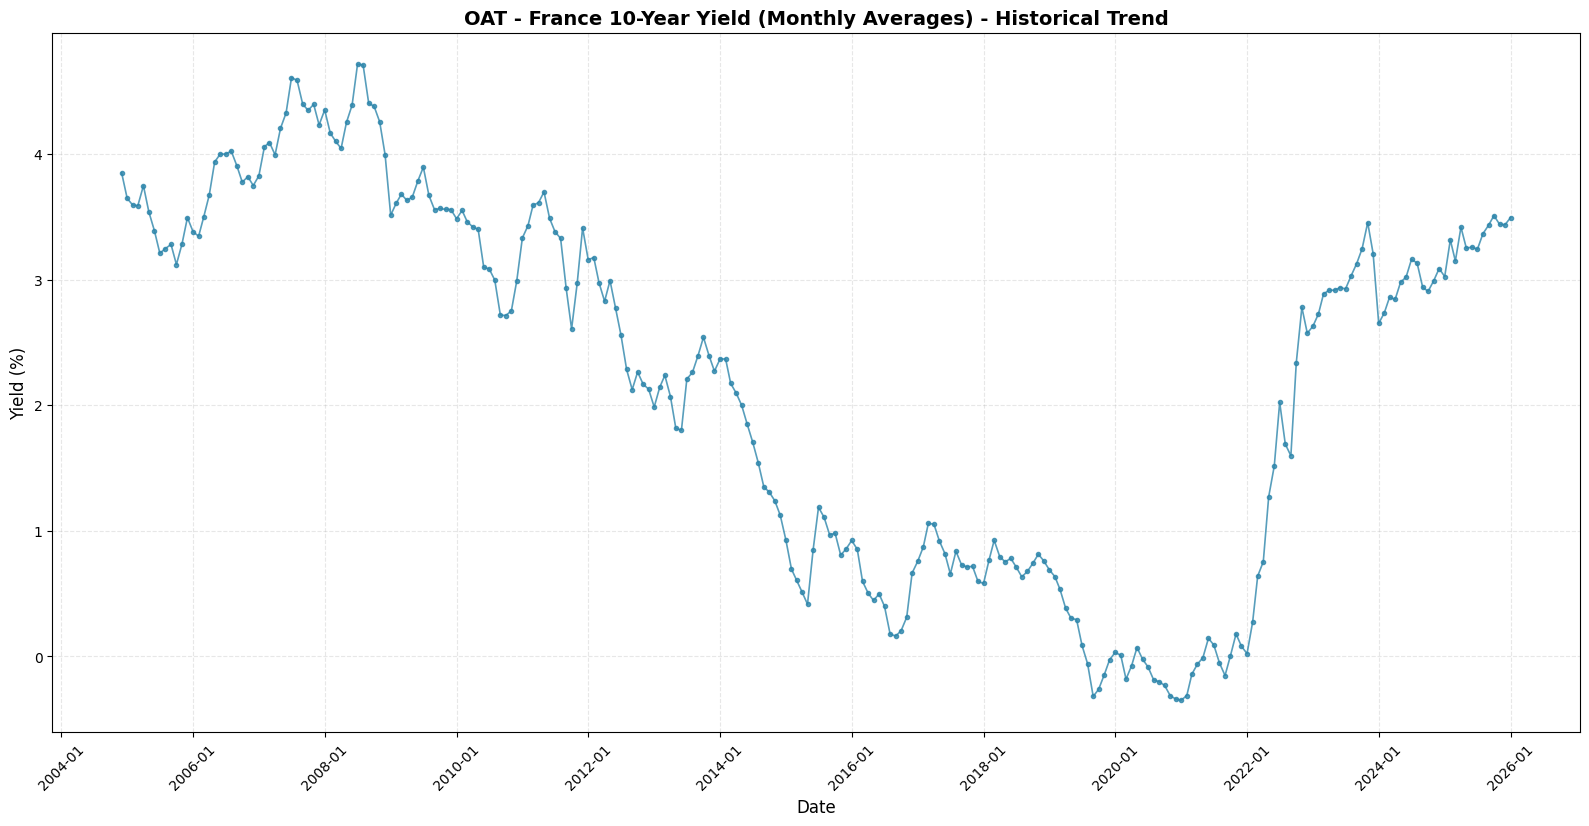

In [8]:
# Create a plot of the monthly data
plt.figure(figsize=(16, 8))
plt.plot(df_output['date'], df_output['value'], linewidth=1.2, color='#2E86AB', alpha=0.8, marker='o', markersize=3)
plt.title('OAT - France 10-Year Yield (Monthly Averages) - Historical Trend', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
plt.xticks(rotation=45)

# Save plot
plot_file = os.path.join(os.path.dirname(output_file), 'FRANCE_10_YEARS_MONTHLY_YIELDS_plot.png')
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_file}")

plt.show()


# Regression Analysis: TEC10_m vs FR10_m

This section performs a linear regression analysis between:
- TEC10_m: France 10-Year Yield monthly averages (from OAT data)
- FR10_m: FR10YT_RR monthly yields (from FR10YT_RR data)


In [9]:
import statsmodels.api as sm


In [10]:
# Read the two CSV files
oat_file = 'data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS.csv'
fr10_file = 'data/oat/FR10YT_RR_MONTLY_YIELDS.csv'

print("Reading OAT file...")
df_oat = pd.read_csv(oat_file)
df_oat['date'] = pd.to_datetime(df_oat['date'], format='%Y-%m-%d', errors='coerce')
df_oat = df_oat.rename(columns={'value': 'TEC10_m'})

print("Reading FR10YT_RR file...")
df_fr10 = pd.read_csv(fr10_file)
df_fr10['date'] = pd.to_datetime(df_fr10['date'], format='%Y-%m-%d', errors='coerce')
df_fr10 = df_fr10.rename(columns={'value': 'FR10_m'})

print(f"\nOAT data shape: {df_oat.shape}")
print(f"OAT date range: {df_oat['date'].min()} to {df_oat['date'].max()}")
print(f"\nFR10YT_RR data shape: {df_fr10.shape}")
print(f"FR10YT_RR date range: {df_fr10['date'].min()} to {df_fr10['date'].max()}")


Reading OAT file...
Reading FR10YT_RR file...

OAT data shape: (254, 2)
OAT date range: 2004-11-30 00:00:00 to 2025-12-31 00:00:00

FR10YT_RR data shape: (479, 2)
FR10YT_RR date range: 1986-01-31 00:00:00 to 2025-11-30 00:00:00


In [11]:
# Merge the two dataframes on date (inner join to keep only common dates)
df_merged = pd.merge(df_oat[['date', 'TEC10_m']], df_fr10[['date', 'FR10_m']], 
                     on='date', how='inner')

# Sort by date
df_merged = df_merged.sort_values(by='date').reset_index(drop=True)

print(f"Merged data shape: {df_merged.shape}")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")
print(f"\nFirst few rows:")
print(df_merged.head(10))
print(f"\nLast few rows:")
print(df_merged.tail(10))
print(f"\nData summary:")
print(df_merged.describe())


Merged data shape: (253, 3)
Date range: 2004-11-30 00:00:00 to 2025-11-30 00:00:00

First few rows:
        date   TEC10_m  FR10_m
0 2004-11-30  3.851786  3.8531
1 2004-12-31  3.646774  3.6432
2 2005-01-31  3.593226  3.5736
3 2005-02-28  3.588929  3.5987
4 2005-03-31  3.748065  3.7462
5 2005-04-30  3.540000  3.5392
6 2005-05-31  3.389032  3.3730
7 2005-06-30  3.210333  3.1987
8 2005-07-31  3.247419  3.2730
9 2005-08-31  3.280323  3.2953

Last few rows:
          date   TEC10_m  FR10_m
243 2025-02-28  3.148214  3.1526
244 2025-03-31  3.417742  3.4784
245 2025-04-30  3.249667  3.2953
246 2025-05-31  3.259677  3.2606
247 2025-06-30  3.241000  3.2362
248 2025-07-31  3.365806  3.3472
249 2025-08-31  3.432903  3.4056
250 2025-09-30  3.510000  3.5172
251 2025-10-31  3.440968  3.4377
252 2025-11-30  3.436667  3.4386

Data summary:
                                date     TEC10_m      FR10_m
count                            253  253.000000  253.000000
mean   2015-05-31 14:59:17.312252928    2.1

In [12]:
# Prepare data for OLS regression
# X: FR10_m (independent variable)
# y: TEC10_m (dependent variable)
X = df_merged['FR10_m']
y = df_merged['TEC10_m']

# Add constant term for intercept
X_with_const = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X_with_const).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                TEC10_m   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.398e+05
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:33:37   Log-Likelihood:                 553.52
No. Observations:                 253   AIC:                            -1103.
Df Residuals:                     251   BIC:                            -1096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0184      0.003     -5.958      0.0

Scatter plot saved to: data/oat/TEC10_vs_FR10_scatter.png


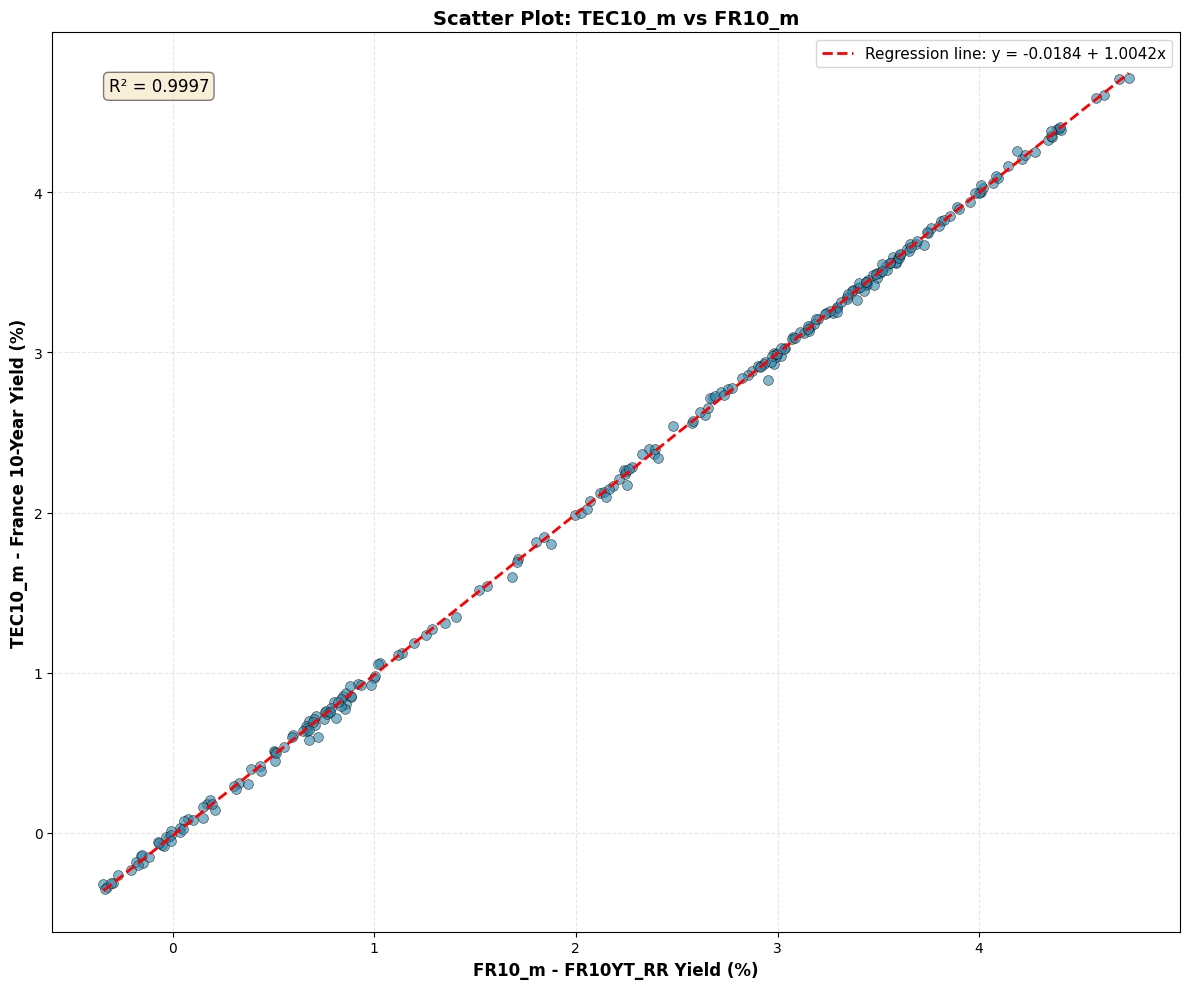

In [13]:
# Create scatter plot: TEC10_m vs FR10_m
plt.figure(figsize=(12, 10))

# Scatter plot
plt.scatter(df_merged['FR10_m'], df_merged['TEC10_m'], 
           alpha=0.6, s=50, color='#2E86AB', edgecolors='black', linewidth=0.5)

# Add regression line
X_plot = df_merged['FR10_m'].sort_values()
y_plot = model.params['const'] + model.params['FR10_m'] * X_plot
plt.plot(X_plot, y_plot, 'r--', linewidth=2, label=f'Regression line: y = {model.params["const"]:.4f} + {model.params["FR10_m"]:.4f}x')

# Add R-squared to the plot
r_squared = model.rsquared
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}', 
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('FR10_m - FR10YT_RR Yield (%)', fontsize=12, fontweight='bold')
plt.ylabel('TEC10_m - France 10-Year Yield (%)', fontsize=12, fontweight='bold')
plt.title('Scatter Plot: TEC10_m vs FR10_m', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=11)
plt.tight_layout()

# Save plot
plot_file = 'data/oat/TEC10_vs_FR10_scatter.png'
os.makedirs(os.path.dirname(plot_file), exist_ok=True)
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Scatter plot saved to: {plot_file}")

plt.show()


# Backcasting TEC10_m (2000-2004)

Using the estimated regression parameters to backcast TEC10_m values for the period 2000-2004 based on FR10_m data.


In [14]:
# Extract regression parameters
alpha = model.params['const']
beta = model.params['FR10_m']

print(f"Regression parameters:")
print(f"  Intercept (alpha): {alpha:.6f}")
print(f"  Coefficient (beta): {beta:.6f}")
print(f"\nRegression equation: TEC10_m = {alpha:.6f} + {beta:.6f} * FR10_m")


Regression parameters:
  Intercept (alpha): -0.018426
  Coefficient (beta): 1.004246

Regression equation: TEC10_m = -0.018426 + 1.004246 * FR10_m


In [15]:
# Filter FR10_m data for backcasting period: 2000-01 to 2004-10
backcast_start = pd.to_datetime('2000-01-31')
backcast_end = pd.to_datetime('2004-10-31')

# Get FR10_m data for the backcasting period
df_fr10_backcast = df_fr10[(df_fr10['date'] >= backcast_start) & (df_fr10['date'] <= backcast_end)].copy()
df_fr10_backcast = df_fr10_backcast.sort_values(by='date').reset_index(drop=True)

print(f"FR10_m data for backcasting period:")
print(f"  Date range: {df_fr10_backcast['date'].min()} to {df_fr10_backcast['date'].max()}")
print(f"  Number of observations: {len(df_fr10_backcast)}")
print(f"\nFirst few rows:")
print(df_fr10_backcast.head(10))
print(f"\nLast few rows:")
print(df_fr10_backcast.tail(10))


FR10_m data for backcasting period:
  Date range: 2000-01-31 00:00:00 to 2004-10-31 00:00:00
  Number of observations: 58

First few rows:
        date  FR10_m
0 2000-01-31  5.6682
1 2000-02-29  5.6293
2 2000-03-31  5.4491
3 2000-04-30  5.3530
4 2000-05-31  5.5014
5 2000-06-30  5.3300
6 2000-07-31  5.4119
7 2000-08-31  5.3677
8 2000-09-30  5.4256
9 2000-10-31  5.3589

Last few rows:
         date  FR10_m
48 2004-01-31  4.1988
49 2004-02-29  4.1390
50 2004-03-31  3.9880
51 2004-04-30  4.1986
52 2004-05-31  4.3455
53 2004-06-30  4.3894
54 2004-07-31  4.2704
55 2004-08-31  4.1086
56 2004-09-30  4.0880
57 2004-10-31  3.9724


In [16]:
# Calculate backcasted TEC10_m values using the regression equation
df_backcast = df_fr10_backcast[['date', 'FR10_m']].copy()
df_backcast['TEC10_m_backcasted'] = alpha + beta * df_backcast['FR10_m']

print(f"Backcasted TEC10_m values:")
print(f"  Date range: {df_backcast['date'].min()} to {df_backcast['date'].max()}")
print(f"  Number of observations: {len(df_backcast)}")
print(f"\nFirst few rows:")
print(df_backcast.head(10))
print(f"\nLast few rows:")
print(df_backcast.tail(10))
print(f"\nSummary statistics:")
print(df_backcast[['FR10_m', 'TEC10_m_backcasted']].describe())


Backcasted TEC10_m values:
  Date range: 2000-01-31 00:00:00 to 2004-10-31 00:00:00
  Number of observations: 58

First few rows:
        date  FR10_m  TEC10_m_backcasted
0 2000-01-31  5.6682            5.673841
1 2000-02-29  5.6293            5.634776
2 2000-03-31  5.4491            5.453811
3 2000-04-30  5.3530            5.357303
4 2000-05-31  5.5014            5.506333
5 2000-06-30  5.3300            5.334205
6 2000-07-31  5.4119            5.416453
7 2000-08-31  5.3677            5.372065
8 2000-09-30  5.4256            5.430211
9 2000-10-31  5.3589            5.363228

Last few rows:
         date  FR10_m  TEC10_m_backcasted
48 2004-01-31  4.1988            4.198202
49 2004-02-29  4.1390            4.138148
50 2004-03-31  3.9880            3.986507
51 2004-04-30  4.1986            4.198001
52 2004-05-31  4.3455            4.345525
53 2004-06-30  4.3894            4.389612
54 2004-07-31  4.2704            4.270106
55 2004-08-31  4.1086            4.107619
56 2004-09-30  4.0880    

In [17]:
# Save backcasted data to CSV
backcast_output_file = 'data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS_BACKCASTED_FR10_2000_2004.csv'
os.makedirs(os.path.dirname(backcast_output_file), exist_ok=True)

# Format date as string for CSV
df_backcast_save = df_backcast[['date', 'TEC10_m_backcasted']].copy()
df_backcast_save = df_backcast_save.rename(columns={'TEC10_m_backcasted': 'value'})
df_backcast_save['date'] = df_backcast_save['date'].dt.strftime('%Y-%m-%d')

df_backcast_save.to_csv(backcast_output_file, index=False)
print(f"Backcasted data saved to: {backcast_output_file}")
print(f"Dimensions: {len(df_backcast_save)} rows, {len(df_backcast_save.columns)} columns")


Backcasted data saved to: data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS_BACKCASTED_FR10_2000_2004.csv
Dimensions: 58 rows, 2 columns


Backcasting plot saved to: data/oat/TEC10_backcasted_FR10_2000_2004_plot.png


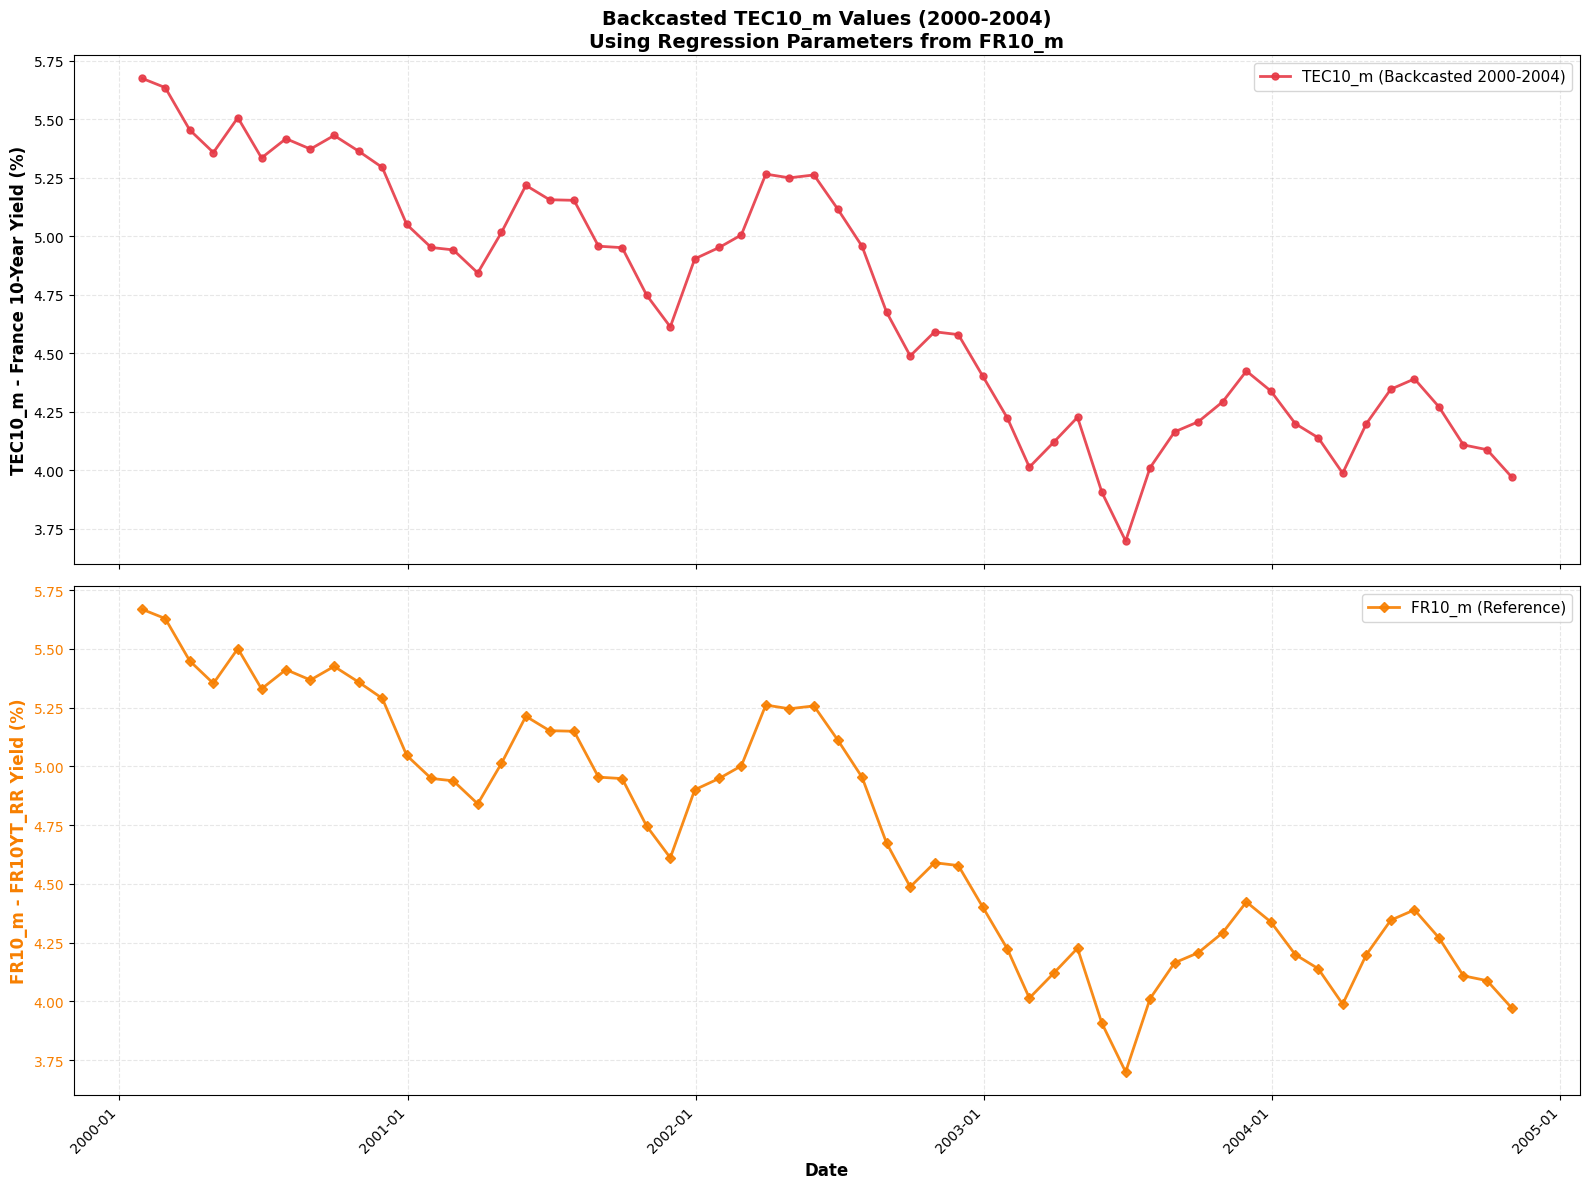

In [18]:
# Create a plot showing the backcasted values using subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Top subplot: TEC10_m (backcasted and actual)
ax1.plot(df_backcast['date'], df_backcast['TEC10_m_backcasted'], 
         linewidth=2, color='#E63946', alpha=0.9, marker='o', markersize=5,
         label='TEC10_m (Backcasted 2000-2004)')

# Plot actual values for comparison (if available in the period)
if 'df_oat' in locals():
    df_oat_plot = df_oat[(df_oat['date'] >= backcast_start) & (df_oat['date'] <= backcast_end)].copy()
    if len(df_oat_plot) > 0:
        ax1.plot(df_oat_plot['date'], df_oat_plot['TEC10_m'], 
                linewidth=2, color='#2E86AB', alpha=0.9, marker='s', markersize=5,
                label='TEC10_m (Actual, if available)')

ax1.set_ylabel('TEC10_m - France 10-Year Yield (%)', fontsize=12, fontweight='bold')
ax1.set_title('Backcasted TEC10_m Values (2000-2004)\nUsing Regression Parameters from FR10_m', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='best', fontsize=11)

# Format x-axis dates for top plot
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Bottom subplot: FR10_m (reference)
ax2.plot(df_backcast['date'], df_backcast['FR10_m'], 
         linewidth=2, color='#F77F00', alpha=0.9, marker='D', markersize=5,
         label='FR10_m (Reference)')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('FR10_m - FR10YT_RR Yield (%)', fontsize=12, fontweight='bold', color='#F77F00')
ax2.tick_params(axis='y', labelcolor='#F77F00')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='best', fontsize=11)

# Format x-axis dates for bottom plot
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

# Save plot
plot_file = 'data/oat/TEC10_backcasted_FR10_2000_2004_plot.png'
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Backcasting plot saved to: {plot_file}")

plt.show()


# Interpolate Daily Values from Monthly Backcasted Data

This section creates daily values from the monthly backcasted data using linear interpolation.


In [19]:
# Read the monthly backcasted data
monthly_backcast_file = 'data/oat/FRANCE_10_YEARS_MONTHLY_YIELDS_BACKCASTED_FR10_2000_2004.csv'

print("Reading monthly backcasted data...")
df_monthly_backcast = pd.read_csv(monthly_backcast_file)
df_monthly_backcast['date'] = pd.to_datetime(df_monthly_backcast['date'], format='%Y-%m-%d', errors='coerce')
df_monthly_backcast = df_monthly_backcast.sort_values(by='date').reset_index(drop=True)

print(f"Monthly backcasted data shape: {df_monthly_backcast.shape}")
print(f"Date range: {df_monthly_backcast['date'].min()} to {df_monthly_backcast['date'].max()}")
print(f"\nFirst few rows:")
print(df_monthly_backcast.head(10))
print(f"\nLast few rows:")
print(df_monthly_backcast.tail(10))


Reading monthly backcasted data...
Monthly backcasted data shape: (58, 2)
Date range: 2000-01-31 00:00:00 to 2004-10-31 00:00:00

First few rows:
        date     value
0 2000-01-31  5.673841
1 2000-02-29  5.634776
2 2000-03-31  5.453811
3 2000-04-30  5.357303
4 2000-05-31  5.506333
5 2000-06-30  5.334205
6 2000-07-31  5.416453
7 2000-08-31  5.372065
8 2000-09-30  5.430211
9 2000-10-31  5.363228

Last few rows:
         date     value
48 2004-01-31  4.198202
49 2004-02-29  4.138148
50 2004-03-31  3.986507
51 2004-04-30  4.198001
52 2004-05-31  4.345525
53 2004-06-30  4.389612
54 2004-07-31  4.270106
55 2004-08-31  4.107619
56 2004-09-30  4.086932
57 2004-10-31  3.970841


In [20]:
# Create a daily date range from the first to the last date in monthly data
start_date = df_monthly_backcast['date'].min()
end_date = df_monthly_backcast['date'].max()

# Generate daily dates
daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')
df_daily_backcast = pd.DataFrame({'date': daily_dates})

print(f"Daily date range created:")
print(f"  Start: {start_date}")
print(f"  End: {end_date}")
print(f"  Total days: {len(df_daily_backcast)}")
print(f"\nFirst few dates:")
print(df_daily_backcast.head(10))
print(f"\nLast few dates:")
print(df_daily_backcast.tail(10))


Daily date range created:
  Start: 2000-01-31 00:00:00
  End: 2004-10-31 00:00:00
  Total days: 1736

First few dates:
        date
0 2000-01-31
1 2000-02-01
2 2000-02-02
3 2000-02-03
4 2000-02-04
5 2000-02-05
6 2000-02-06
7 2000-02-07
8 2000-02-08
9 2000-02-09

Last few dates:
           date
1726 2004-10-22
1727 2004-10-23
1728 2004-10-24
1729 2004-10-25
1730 2004-10-26
1731 2004-10-27
1732 2004-10-28
1733 2004-10-29
1734 2004-10-30
1735 2004-10-31


In [21]:
# Merge daily dates with monthly data
# First, set date as index for monthly data to enable reindexing
df_monthly_indexed = df_monthly_backcast.set_index('date')

# Reindex to daily frequency and interpolate linearly
df_daily_backcast = df_daily_backcast.set_index('date')
# Interpolate linearly between monthly values
# This will create smooth daily values between each pair of monthly data points
df_daily_backcast['value'] = df_monthly_indexed['value'].reindex(df_daily_backcast.index).interpolate(method='linear')

# Reset index to have date as column
df_daily_backcast = df_daily_backcast.reset_index()

print(f"Daily interpolated data:")
print(f"  Total days: {len(df_daily_backcast)}")
print(f"  Missing values: {df_daily_backcast['value'].isna().sum()}")
print(f"\nFirst few rows:")
print(df_daily_backcast.head(15))
print(f"\nLast few rows:")
print(df_daily_backcast.tail(15))
print(f"\nSummary statistics:")
print(df_daily_backcast['value'].describe())


Daily interpolated data:
  Total days: 1736
  Missing values: 0

First few rows:
         date     value
0  2000-01-31  5.673841
1  2000-02-01  5.672494
2  2000-02-02  5.671147
3  2000-02-03  5.669800
4  2000-02-04  5.668453
5  2000-02-05  5.667106
6  2000-02-06  5.665759
7  2000-02-07  5.664412
8  2000-02-08  5.663065
9  2000-02-09  5.661718
10 2000-02-10  5.660370
11 2000-02-11  5.659023
12 2000-02-12  5.657676
13 2000-02-13  5.656329
14 2000-02-14  5.654982

Last few rows:
           date     value
1721 2004-10-17  4.023269
1722 2004-10-18  4.019524
1723 2004-10-19  4.015779
1724 2004-10-20  4.012034
1725 2004-10-21  4.008290
1726 2004-10-22  4.004545
1727 2004-10-23  4.000800
1728 2004-10-24  3.997055
1729 2004-10-25  3.993310
1730 2004-10-26  3.989565
1731 2004-10-27  3.985820
1732 2004-10-28  3.982076
1733 2004-10-29  3.978331
1734 2004-10-30  3.974586
1735 2004-10-31  3.970841

Summary statistics:
count    1736.000000
mean        4.725239
std         0.515981
min         3.69668

In [22]:
# Save daily backcasted data to CSV
daily_backcast_output_file = 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS_BACKCASTED_FR10_2000_2004.csv'
os.makedirs(os.path.dirname(daily_backcast_output_file), exist_ok=True)

# Format date as string for CSV
df_daily_backcast_save = df_daily_backcast.copy()
df_daily_backcast_save['date'] = df_daily_backcast_save['date'].dt.strftime('%Y-%m-%d')

df_daily_backcast_save.to_csv(daily_backcast_output_file, index=False)
print(f"Daily backcasted data saved to: {daily_backcast_output_file}")
print(f"Dimensions: {len(df_daily_backcast_save)} rows, {len(df_daily_backcast_save.columns)} columns")


Daily backcasted data saved to: data/oat/FRANCE_10_YEARS_DAILY_YIELDS_BACKCASTED_FR10_2000_2004.csv
Dimensions: 1736 rows, 2 columns


Daily backcasting plot saved to: data/oat/TEC10_daily_backcasted_FR10_2000_2004_plot.png


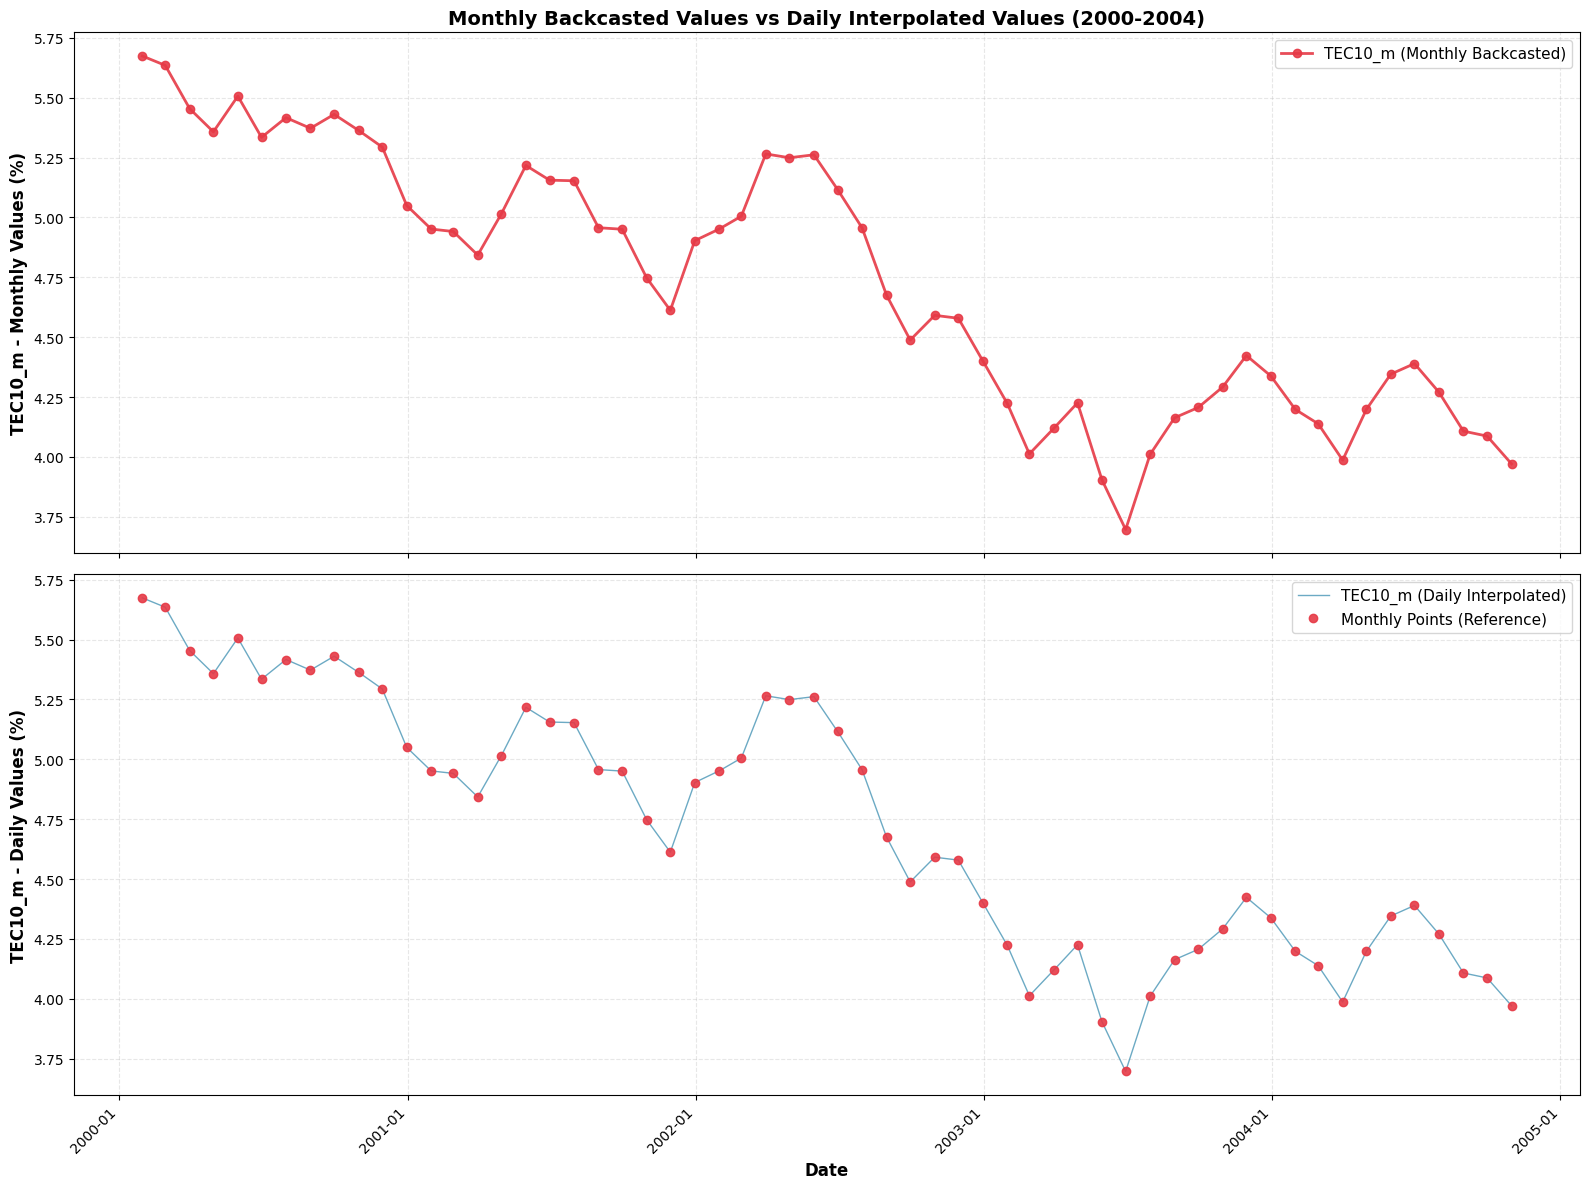

In [23]:
# Create a plot showing monthly vs daily interpolated values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Top subplot: Monthly backcasted values
ax1.plot(df_monthly_backcast['date'], df_monthly_backcast['value'], 
         linewidth=2, color='#E63946', alpha=0.9, marker='o', markersize=6,
         label='TEC10_m (Monthly Backcasted)')
ax1.set_ylabel('TEC10_m - Monthly Values (%)', fontsize=12, fontweight='bold')
ax1.set_title('Monthly Backcasted Values vs Daily Interpolated Values (2000-2004)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='best', fontsize=11)

# Format x-axis dates for top plot
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Bottom subplot: Daily interpolated values
ax2.plot(df_daily_backcast['date'], df_daily_backcast['value'], 
         linewidth=1, color='#2E86AB', alpha=0.7,
         label='TEC10_m (Daily Interpolated)')
# Also plot monthly points for reference
ax2.plot(df_monthly_backcast['date'], df_monthly_backcast['value'], 
         linewidth=0, color='#E63946', alpha=0.9, marker='o', markersize=6,
         label='Monthly Points (Reference)')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('TEC10_m - Daily Values (%)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='best', fontsize=11)

# Format x-axis dates for bottom plot
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

# Save plot
plot_file = 'data/oat/TEC10_daily_backcasted_FR10_2000_2004_plot.png'
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Daily backcasting plot saved to: {plot_file}")

plt.show()


# Merge Backcasted and Actual Daily Data

This section merges the backcasted daily data (2000-2004) with the actual daily data (2004+), giving priority to actual data when dates overlap, and applying backward fill for any gaps.


In [24]:
# Read both CSV files
backcasted_file = 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS_BACKCASTED_FR10_2000_2004.csv'
actual_file = 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS.csv'

print("Reading backcasted daily data...")
df_backcasted = pd.read_csv(backcasted_file)
df_backcasted['date'] = pd.to_datetime(df_backcasted['date'], format='%Y-%m-%d', errors='coerce')
df_backcasted = df_backcasted.sort_values(by='date').reset_index(drop=True)

print("Reading actual daily data...")
df_actual = pd.read_csv(actual_file)
df_actual['date'] = pd.to_datetime(df_actual['date'], format='%Y-%m-%d', errors='coerce')
df_actual = df_actual.sort_values(by='date').reset_index(drop=True)

print(f"\nBackcasted data:")
print(f"  Shape: {df_backcasted.shape}")
print(f"  Date range: {df_backcasted['date'].min()} to {df_backcasted['date'].max()}")
print(f"\nActual data:")
print(f"  Shape: {df_actual.shape}")
print(f"  Date range: {df_actual['date'].min()} to {df_actual['date'].max()}")


Reading backcasted daily data...
Reading actual daily data...

Backcasted data:
  Shape: (1736, 2)
  Date range: 2000-01-31 00:00:00 to 2004-10-31 00:00:00

Actual data:
  Shape: (7703, 2)
  Date range: 2004-11-03 00:00:00 to 2025-12-05 00:00:00


In [25]:
# Merge the two dataframes
# Strategy: 
# 1. Start with backcasted data
# 2. Add/overwrite with actual data (actual data has priority)
# 3. Sort by date
# 4. Apply backward fill for any gaps

# Combine both dataframes, giving priority to actual data
df_merged = pd.concat([df_backcasted, df_actual], ignore_index=True)

# Remove duplicates, keeping the last occurrence (which will be from actual if both exist)
df_merged = df_merged.drop_duplicates(subset='date', keep='last')

# Sort by date
df_merged = df_merged.sort_values(by='date').reset_index(drop=True)

print(f"Merged data (before bfill):")
print(f"  Shape: {df_merged.shape}")
print(f"  Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")
print(f"  Missing values: {df_merged['value'].isna().sum()}")
print(f"\nFirst few rows:")
print(df_merged.head(10))
print(f"\nLast few rows:")
print(df_merged.tail(10))


Merged data (before bfill):
  Shape: (9439, 2)
  Date range: 2000-01-31 00:00:00 to 2025-12-05 00:00:00
  Missing values: 0

First few rows:
        date     value
0 2000-01-31  5.673841
1 2000-02-01  5.672494
2 2000-02-02  5.671147
3 2000-02-03  5.669800
4 2000-02-04  5.668453
5 2000-02-05  5.667106
6 2000-02-06  5.665759
7 2000-02-07  5.664412
8 2000-02-08  5.663065
9 2000-02-09  5.661718

Last few rows:
           date  value
9429 2025-11-26   3.41
9430 2025-11-27   3.41
9431 2025-11-28   3.41
9432 2025-11-29   3.45
9433 2025-11-30   3.45
9434 2025-12-01   3.45
9435 2025-12-02   3.49
9436 2025-12-03   3.50
9437 2025-12-04   3.50
9438 2025-12-05   3.53


In [26]:
# Check for gaps in the date range and apply backward fill
# First, create a complete date range from min to max date
start_date = df_merged['date'].min()
end_date = df_merged['date'].max()
complete_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a dataframe with all dates
df_complete = pd.DataFrame({'date': complete_dates})

# Merge with existing data
df_complete = df_complete.merge(df_merged, on='date', how='left')

# Apply backward fill to fill any gaps
df_complete['value'] = df_complete['value'].bfill()

# Sort by date
df_complete = df_complete.sort_values(by='date').reset_index(drop=True)

print(f"Complete data (after bfill):")
print(f"  Shape: {df_complete.shape}")
print(f"  Date range: {df_complete['date'].min()} to {df_complete['date'].max()}")
print(f"  Missing values: {df_complete['value'].isna().sum()}")
print(f"\nFirst few rows:")
print(df_complete.head(15))
print(f"\nLast few rows:")
print(df_complete.tail(15))
print(f"\nSummary statistics:")
print(df_complete['value'].describe())


Complete data (after bfill):
  Shape: (9441, 2)
  Date range: 2000-01-31 00:00:00 to 2025-12-05 00:00:00
  Missing values: 0

First few rows:
         date     value
0  2000-01-31  5.673841
1  2000-02-01  5.672494
2  2000-02-02  5.671147
3  2000-02-03  5.669800
4  2000-02-04  5.668453
5  2000-02-05  5.667106
6  2000-02-06  5.665759
7  2000-02-07  5.664412
8  2000-02-08  5.663065
9  2000-02-09  5.661718
10 2000-02-10  5.660370
11 2000-02-11  5.659023
12 2000-02-12  5.657676
13 2000-02-13  5.656329
14 2000-02-14  5.654982

Last few rows:
           date  value
9426 2025-11-21   3.46
9427 2025-11-22   3.45
9428 2025-11-23   3.45
9429 2025-11-24   3.45
9430 2025-11-25   3.45
9431 2025-11-26   3.41
9432 2025-11-27   3.41
9433 2025-11-28   3.41
9434 2025-11-29   3.45
9435 2025-11-30   3.45
9436 2025-12-01   3.45
9437 2025-12-02   3.49
9438 2025-12-03   3.50
9439 2025-12-04   3.50
9440 2025-12-05   3.53

Summary statistics:
count    9441.000000
mean        2.661730
std         1.669634
min   

In [27]:
# Save merged data to CSV
merged_output_file = 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS_MERGED_FR10.csv'
os.makedirs(os.path.dirname(merged_output_file), exist_ok=True)

# Format date as string for CSV
df_complete_save = df_complete.copy()
df_complete_save['date'] = df_complete_save['date'].dt.strftime('%Y-%m-%d')

df_complete_save.to_csv(merged_output_file, index=False)
print(f"Merged data saved to: {merged_output_file}")
print(f"Dimensions: {len(df_complete_save)} rows, {len(df_complete_save.columns)} columns")


Merged data saved to: data/oat/FRANCE_10_YEARS_DAILY_YIELDS_MERGED_FR10.csv
Dimensions: 9441 rows, 2 columns


Merged data plot saved to: data/oat/FRANCE_10_YEARS_DAILY_YIELDS_MERGED_FR10_plot.png


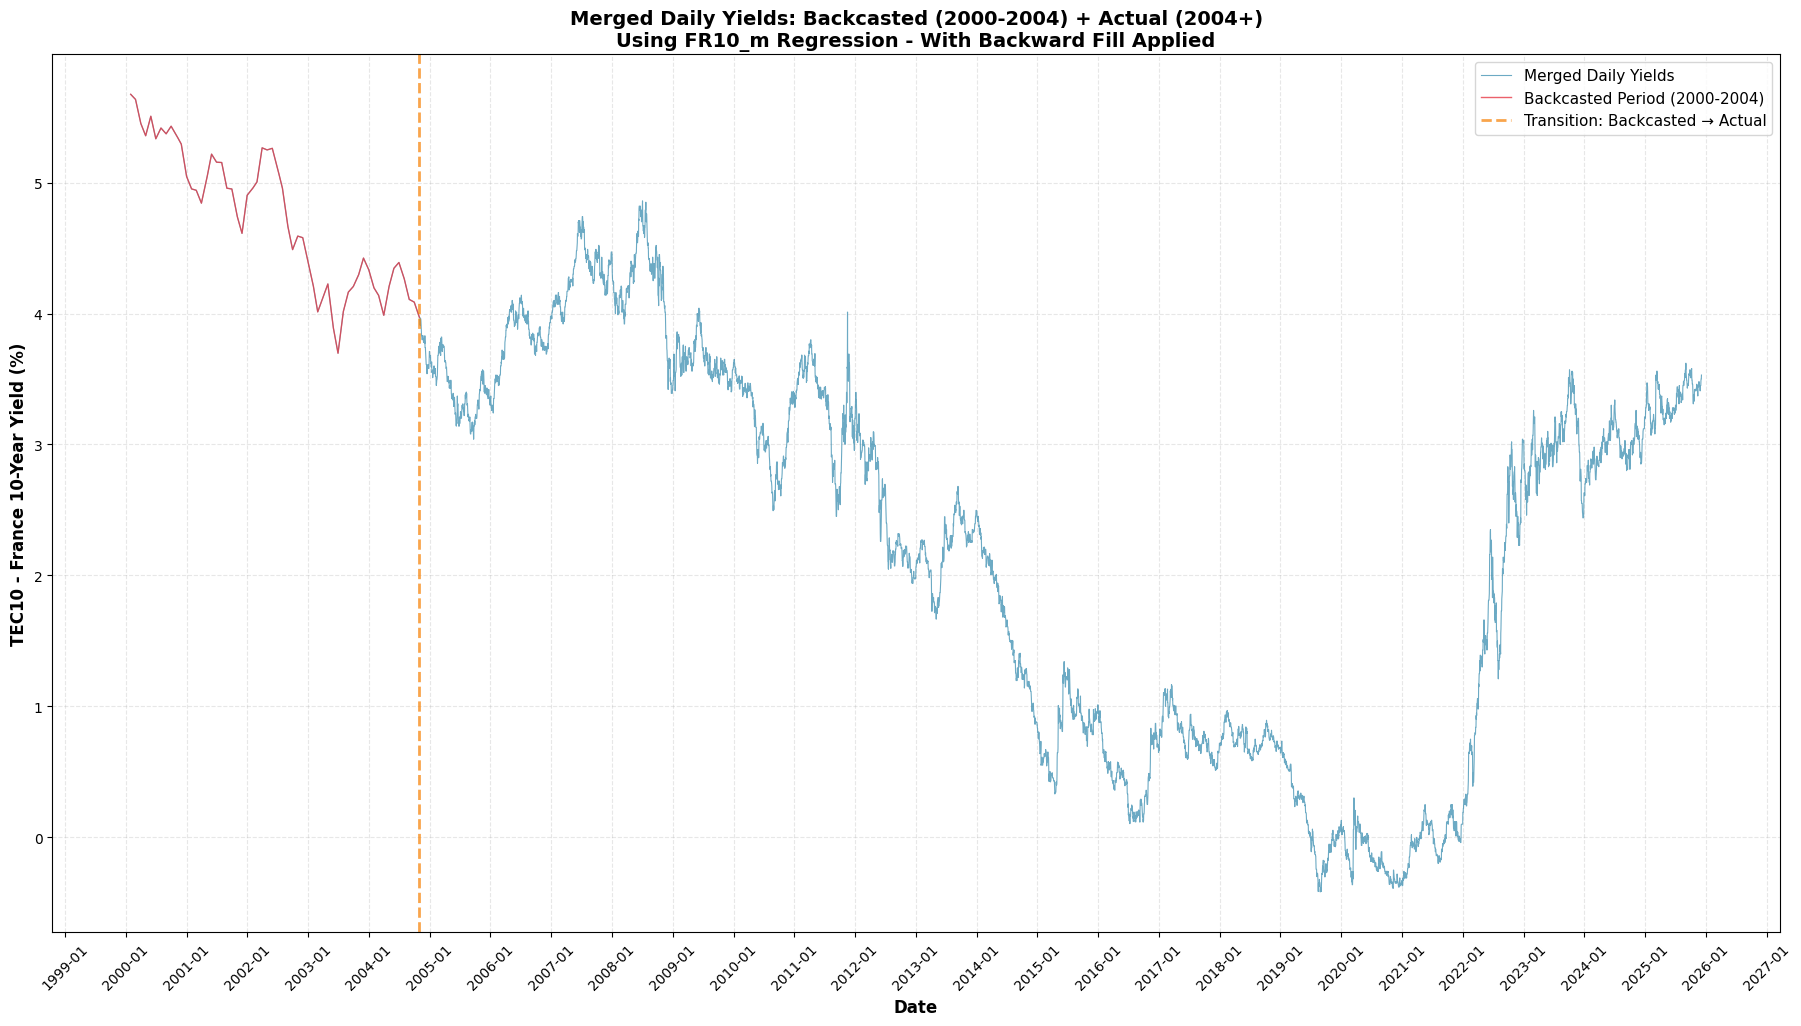

In [28]:
# Create a plot showing the merged data
plt.figure(figsize=(18, 10))

# Plot the entire merged series
plt.plot(df_complete['date'], df_complete['value'], 
         linewidth=0.8, color='#2E86AB', alpha=0.7,
         label='Merged Daily Yields')

# Highlight the backcasted period (2000-2004)
backcast_end = pd.to_datetime('2004-10-31')
df_backcasted_plot = df_complete[df_complete['date'] <= backcast_end].copy()
if len(df_backcasted_plot) > 0:
    plt.plot(df_backcasted_plot['date'], df_backcasted_plot['value'], 
            linewidth=1, color='#E63946', alpha=0.8,
            label='Backcasted Period (2000-2004)')

# Add vertical line to show transition point
if len(df_backcasted_plot) > 0:
    plt.axvline(x=backcast_end, color='#F77F00', linestyle='--', linewidth=2, 
               alpha=0.7, label='Transition: Backcasted → Actual')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('TEC10 - France 10-Year Yield (%)', fontsize=12, fontweight='bold')
plt.title('Merged Daily Yields: Backcasted (2000-2004) + Actual (2004+)\nUsing FR10_m Regression - With Backward Fill Applied', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=11)
plt.tight_layout()

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show every 2 years
plt.xticks(rotation=45)

# Save plot
plot_file = 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS_MERGED_FR10_plot.png'
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Merged data plot saved to: {plot_file}")

plt.show()
